In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # much faster than svg when generating lots of points
import statsmodels.formula.api as smf
import statsmodels.stats.anova as sa
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
# set print precision
np.set_printoptions(precision=5, suppress=True)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [8]:
# load train data to build model
df = pd.read_csv('data/train.csv')

In [9]:
df['type']

0      Paid
1      Paid
2      Paid
3      Paid
4      Paid
       ... 
427    Paid
428    Paid
429    Paid
430    Paid
431    Paid
Name: type, Length: 432, dtype: object

In [1]:
df.head()

NameError: name 'pd' is not defined

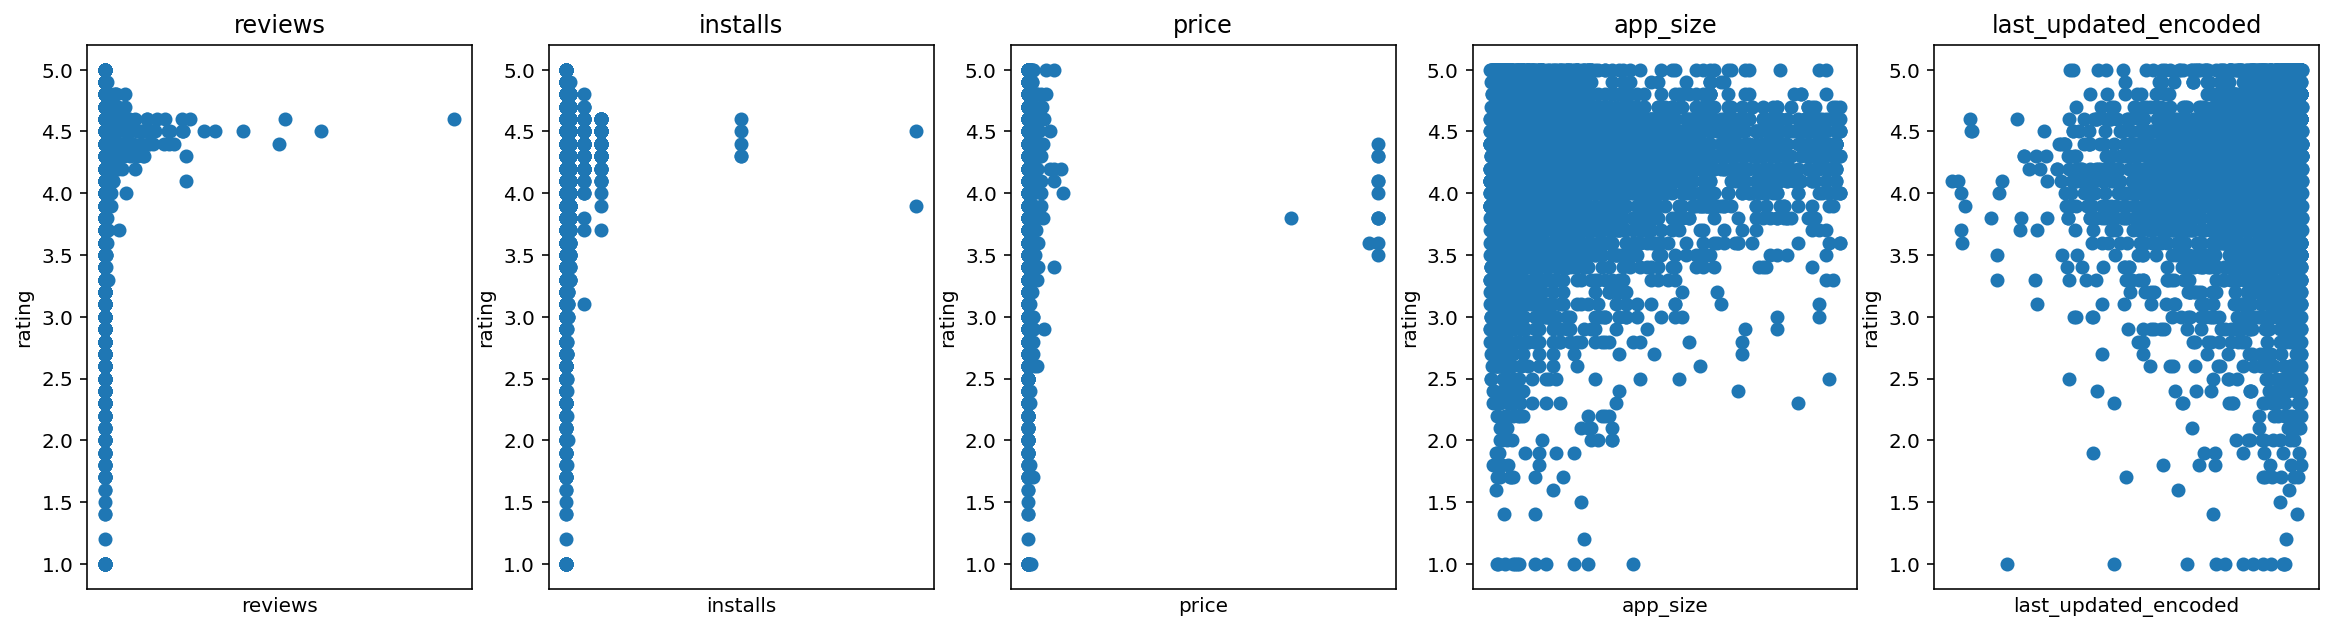

In [3]:
#scatter plots for numerical variables

plt.figure(figsize=(20, 5))
numerical_variables = ['reviews','installs','price','app_size','last_updated_encoded']

for i, col in enumerate(numerical_variables):
    plt.subplot(1, 5, i+1)
    x = df[col]
    y = df['rating']
    plt.plot(x, y, 'o')
    plt.xticks([])
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('rating')

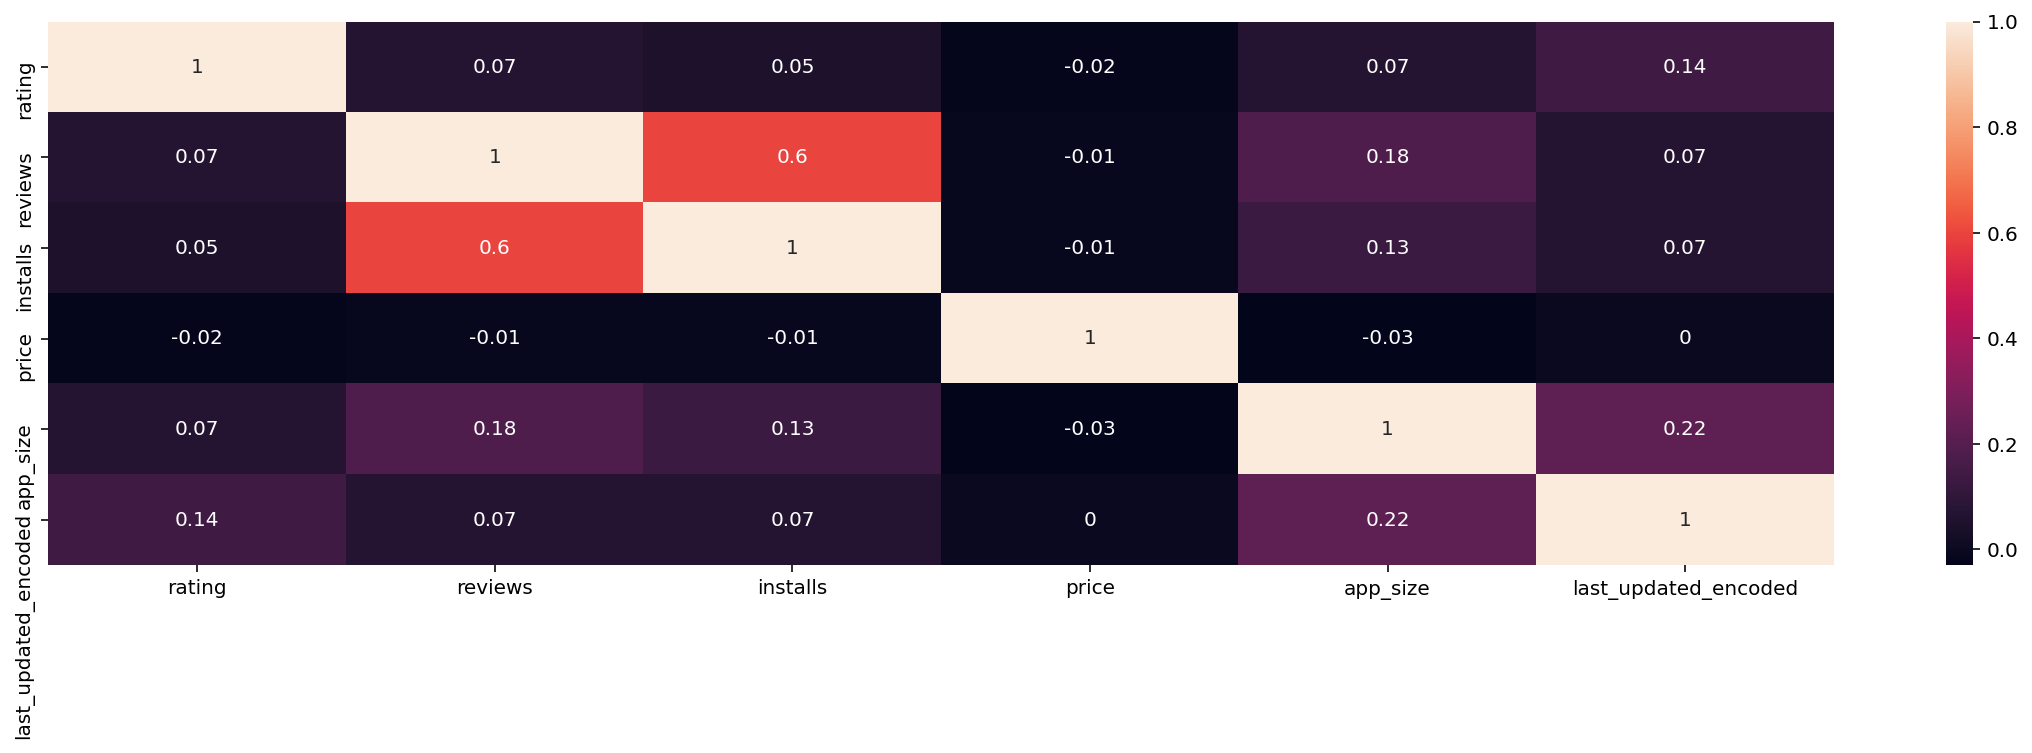

In [4]:
#checking multicollinearity.From heat map seems like reviews and installs are correlated.
import seaborn as sns
correlation_matrix = df.corr().round(2)
plt.figure(figsize = (20,5))
sns.heatmap(data=correlation_matrix, annot=True)

In [5]:
#the vif scores are checked here and content rating has high vif and some of the dummy variables in category too
from patsy import dmatrices
ystr = 'rating'
xstr = '+'.join([col for col in df.columns if col != ystr])
y, X = dmatrices(f'{ystr}~{xstr}', data=df, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

    VIF Factor                         features
0   3043.28112                        Intercept
1      2.06968    category[T.Auto_And_Vehicles]
2      1.60944               category[T.Beauty]
3      3.38238  category[T.Books_And_Reference]
4      4.68385             category[T.Business]
5      1.77733               category[T.Comics]
6      4.07167        category[T.Communication]
7      3.53293               category[T.Dating]
8      2.27958            category[T.Education]
9      2.02654        category[T.Entertainment]
10     1.73436               category[T.Events]
11    21.74030               category[T.Family]
12     5.27998              category[T.Finance]
13     2.21411       category[T.Food_And_Drink]
14    13.73395                 category[T.Game]
15     4.18982   category[T.Health_And_Fitness]
16     1.88141       category[T.House_And_Home]
17     2.00989   category[T.Libraries_And_Demo]
18     5.16488            category[T.Lifestyle]
19     2.74839  category[T.Maps_And_Navi

In [6]:
#checking vif scores again after removing content_rating. Now the vif scores seems good and the predictor variables are not correlated

y, X = dmatrices('rating~reviews+installs+price+app_size+last_updated_encoded+category+type', data=df, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

    VIF Factor                         features
0    177.41863                        Intercept
1      2.06926    category[T.Auto_And_Vehicles]
2      1.60916               category[T.Beauty]
3      3.38201  category[T.Books_And_Reference]
4      4.68222             category[T.Business]
5      1.75494               category[T.Comics]
6      4.07045        category[T.Communication]
7      2.97100               category[T.Dating]
8      2.27880            category[T.Education]
9      2.00727        category[T.Entertainment]
10     1.73418               category[T.Events]
11    21.72301               category[T.Family]
12     5.27781              category[T.Finance]
13     2.21404       category[T.Food_And_Drink]
14    13.61635                 category[T.Game]
15     4.18884   category[T.Health_And_Fitness]
16     1.88119       category[T.House_And_Home]
17     2.00927   category[T.Libraries_And_Demo]
18     5.16411            category[T.Lifestyle]
19     2.74739  category[T.Maps_And_Navi

In [7]:
#model without content_rating because it has high vif scores
model = smf.ols('rating~reviews+installs+price+app_size+last_updated_encoded+category+type', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     9.349
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           3.08e-51
Time:                        15:22:16   Log-Likelihood:                -4527.5
No. Observations:                5623   AIC:                             9133.
Df Residuals:                    5584   BIC:                             9392.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

#### The t test shows that except installs and app_size, others are significant predictors of rating,given others are already in the model, since it is a marginal t test.
#### But the price has p-value close to rejection.
#### Also, the r_2 value is really low.Does this mean that these variables are not correctly explaining the model?


In [8]:
# The partial and sequential anova to re-confirm the t- test values
partial = sm.stats.anova_lm(model, typ=2)
seq = sm.stats.anova_lm(model, typ=1)

print('~~~~~~~ Partial ANOVA ~~~~~~~')
print(partial)

print('\n~~~~~~~ Sequential ANOVA ~~~~~~~')
print(seq)

~~~~~~~ Partial ANOVA ~~~~~~~
                         sum_sq         df         F  PR(>F)
category               55.84632   32.00000   5.91459 0.00000
type                    5.31843    1.00000  18.02452 0.00002
reviews                 2.50668    1.00000   8.49532 0.00357
installs                0.07786    1.00000   0.26389 0.60748
price                   1.12058    1.00000   3.79773 0.05137
app_size                0.03514    1.00000   0.11908 0.73005
last_updated_encoded   35.23911    1.00000 119.42773 0.00000
Residual             1647.65087 5584.00000       nan     nan

~~~~~~~ Sequential ANOVA ~~~~~~~
                             df     sum_sq  mean_sq         F  PR(>F)
category               32.00000   58.57447  1.83045   6.20353 0.00000
type                    1.00000    1.48364  1.48364   5.02816 0.02498
reviews                 1.00000    6.81142  6.81142  23.08436 0.00000
installs                1.00000    0.24727  0.24727   0.83803 0.36000
price                   1.00000    0.

#### The partial anova gives same inferences as t-test.But need to check the sequential anova in different combinations of predictors

In [10]:
# removed app_size and installs and with reviews first and others later(Don't know why always the categorical variables are shown first in t test and anova test)
model1 = smf.ols('rating~category+type+reviews+last_updated_encoded+price' , data=df).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     9.860
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           3.67e-52
Time:                        15:45:48   Log-Likelihood:                -4527.7
No. Observations:                5623   AIC:                             9129.
Df Residuals:                    5586   BIC:                             9375.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [11]:
seq1 = sm.stats.anova_lm(model1, typ=1)   #price not so much significant
print(seq1)

                             df     sum_sq  mean_sq         F  PR(>F)
category               32.00000   58.57447  1.83045   6.20533 0.00000
type                    1.00000    1.48364  1.48364   5.02962 0.02496
reviews                 1.00000    6.81142  6.81142  23.09107 0.00000
last_updated_encoded    1.00000   36.73610 36.73610 124.53731 0.00000
price                   1.00000    1.10561  1.10561   3.74808 0.05292
Residual             5586.00000 1647.76198  0.29498       nan     nan


In [12]:
model2 = smf.ols('rating~category+type+price+reviews+last_updated_encoded' , data=df).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     9.860
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           3.67e-52
Time:                        15:47:27   Log-Likelihood:                -4527.7
No. Observations:                5623   AIC:                             9129.
Df Residuals:                    5586   BIC:                             9375.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [13]:
seq2 = sm.stats.anova_lm(model2, typ=1)  #price first
print(seq2)

                             df     sum_sq  mean_sq         F  PR(>F)
category               32.00000   58.57447  1.83045   6.20533 0.00000
type                    1.00000    1.48364  1.48364   5.02962 0.02496
price                   1.00000    0.70409  0.70409   2.38692 0.12241
reviews                 1.00000    6.83536  6.83536  23.17222 0.00000
last_updated_encoded    1.00000   37.11368 37.11368 125.81732 0.00000
Residual             5586.00000 1647.76198  0.29498       nan     nan


In [15]:
model3 = smf.ols('rating~category+type+reviews+last_updated_encoded' , data=df).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     10.03
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           6.25e-52
Time:                        15:49:16   Log-Likelihood:                -4529.6
No. Observations:                5623   AIC:                             9131.
Df Residuals:                    5587   BIC:                             9370.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [16]:
seq3 = sm.stats.anova_lm(model3, typ=1)  #no price
print(seq3)

                             df     sum_sq  mean_sq         F  PR(>F)
category               32.00000   58.57447  1.83045   6.20228 0.00000
type                    1.00000    1.48364  1.48364   5.02715 0.02499
reviews                 1.00000    6.81142  6.81142  23.07971 0.00000
last_updated_encoded    1.00000   36.73610 36.73610 124.47608 0.00000
Residual             5587.00000 1648.86759  0.29513       nan     nan


In [17]:
model4 = smf.ols('rating~category+price+reviews+last_updated_encoded' , data=df).fit() #no type
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     9.602
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           3.70e-49
Time:                        15:50:26   Log-Likelihood:                -4536.7
No. Observations:                5623   AIC:                             9145.
Df Residuals:                    5587   BIC:                             9384.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [18]:
seq4 = sm.stats.anova_lm(model4, typ=1)  #no type
print(seq4)

                             df     sum_sq  mean_sq         F  PR(>F)
category               32.00000   58.57447  1.83045   6.18663 0.00000
price                   1.00000    0.28777  0.28777   0.97263 0.32407
reviews                 1.00000    6.51796  6.51796  22.02965 0.00000
last_updated_encoded    1.00000   34.05463 34.05463 115.09909 0.00000
Residual             5587.00000 1653.03838  0.29587       nan     nan


In [19]:
model5 = smf.ols('rating~category+reviews+last_updated_encoded' , data=df).fit() #no type and price
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     9.856
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           1.80e-49
Time:                        15:51:30   Log-Likelihood:                -4537.2
No. Observations:                5623   AIC:                             9144.
Df Residuals:                    5588   BIC:                             9377.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [22]:
seq5 = sm.stats.anova_lm(model5, typ=1)  #no type and price
print(seq5)

                             df     sum_sq  mean_sq         F  PR(>F)
category               32.00000   58.57447  1.83045   6.18668 0.00000
reviews                 1.00000    6.53033  6.53033  22.07160 0.00000
last_updated_encoded    1.00000   34.04631 34.04631 115.07181 0.00000
Residual             5588.00000 1653.32211  0.29587       nan     nan


#### category,reviews and last_updated encoded are taken as significant predictors of rating.